In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import r2_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cpu


In [3]:
# Architectures
    
class GlyNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(GlyNet, self).__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [5]:
# Functions

def log(values):
    """Log base 10."""
    return np.log10(values - values.min() + 1)

def z_score(values):
    """Z-Score from Mean Absolute Deviation."""
    diff = values - values.median()
    mad = diff.abs().median()
    return (0.6745 * (diff)) / mad

In [4]:
# Data

def get_data(choice=None):
    """Get IUPAC, fingerprint and log RFU data.
    choice: Choice of sample. If None, all samples used. Default: None"""
    iupac_data = pd.read_csv('Data/IUPAC.csv').dropna()
    iupacs = iupac_data['IUPAC'].tolist()
    fingpr_data = pd.read_csv('Data/Fingerprints.csv')
    fingpr_data = fingpr_data.drop('IUPAC', axis=1)
    fingprs = fingpr_data.values.tolist()
    rfu_data = pd.read_csv('Data/Avg. RFU.csv').dropna()
    rfu_data = rfu_data.drop('Index', axis=1).apply(log)
    rfu_data = rfu_data[[choice]] if choice else rfu_data
    rfus = rfu_data.values.tolist()
    data = list(zip(iupacs, fingprs, rfus))
    samples = rfu_data.columns.tolist()
    in_dim = len(fingpr_data.columns)
    out_dim = len(rfu_data.columns)
    return data, samples, in_dim, out_dim

def ten_fold(data):
    """10-fold cross validation with random sampling."""
    random.shuffle(data)
    sections = []
    assert len(data) == 600
    for i in range(0, 600, 100):
        section = data[i:i + 100]
        sections.append(section)
    for i in range(10):
        held_out = []
        for section in sections:
            random.shuffle(section)
            sample = section[:10]
            del section[:10]
            held_out += sample
        kept_in = [pair for pair in data if not pair in held_out]
        yield held_out, kept_in

def prepare_data(data, mode='train'):
    """Prepare inputs and desired outputs for training or testing.
    mode: Prepare data for 'test' or 'train'. Default: 'train'"""
    fingpr_tensors, rfu_tensors = [], []
    for iupac, fingpr, rfu in data:
        fingpr_tensor = torch.tensor(fingpr).float().to(device)
        rfu_tensor = torch.tensor(rfu).float().to(device)
        fingpr_tensors.append(fingpr_tensor)
        rfu_tensors.append(rfu_tensor)
    if mode == 'train':
        trainset = list(zip(fingpr_tensors, rfu_tensors))
        return torch.utils.data.DataLoader(trainset, batch_size=64)
    elif mode == 'test':
        fingpr_stack = torch.stack(fingpr_tensors).float().to(device)
        rfu_stack = torch.stack(rfu_tensors).float().to(device)
        return fingpr_stack, rfu_stack

In [6]:
# Training

def early_stop(losses, patience):
    """Return True if the loss hasn't improved for a number of epochs.
    patience: Number of epochs without improvement."""
    if min(losses) < min(losses[-patience:]):
        return True

def train(n_hidden=800, patience=10, choice=None, plot=False):
    """Train GlyNet using 10-fold cross-validation on the CFG data.
    n_hidden: Number of neurons in a hidden layer. Default: 800
    patience: Number of epochs without improvement. Default: 10
    choice: Choice of sample. If None, all samples used. Default: None
    plot: Plot loss for every epoch. Default: False"""
    data, samples, in_dim, out_dim = get_data(choice)
    net = GlyNet(in_dim, n_hidden, out_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), weight_decay=1e-4)
    glycans, actual, predicted = [], [], []
    for i, (held_out, kept_in) in enumerate(ten_fold(data)):
        train_losses, test_losses = [], []
        trainloader = prepare_data(kept_in, mode='train')
        print('Fold', i + 1, 'Held Out')
        for layer in net.children():
            layer.reset_parameters()
        for epoch in range(1000):
            batch_loss = 0.0
            for inputs, values in trainloader:
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(values, outputs)
                loss.backward()
                optimizer.step()
                batch_size, _ = values.size()
                batch_loss += loss.item() * batch_size
            train_loss = batch_loss / len(kept_in)
            train_losses.append(train_loss)
            test_inputs, test_values = prepare_data(held_out, mode='test')
            with torch.no_grad():
                test_outputs = net(test_inputs)
                test_loss = criterion(test_values, test_outputs)
            test_losses.append(test_loss.item())
            if early_stop(test_losses, patience):
                break
        glycans += [iupac for iupac, fingpr, rfu in held_out]
        actual += [rfu for iupac, fingpr, rfu in held_out]
        predicted += test_outputs.tolist()
        print('Train Loss:', round(train_loss, 4))
        print('Test Loss:', round(test_loss.item(), 4), '\n')
        if plot:
            plot_performance(train_losses, test_losses)
    print('GlyNet Cross-Validation Complete')
    act_data = pd.DataFrame(actual, columns=samples, index=glycans)
    pred_data = pd.DataFrame(predicted, columns=samples, index=glycans)
    return act_data, pred_data

In [7]:
# Visuals

def plot_performance(train_losses, test_losses):
    """Plots training and test loss."""
    plt.plot(train_losses, label = 'Train Loss')
    plt.plot(test_losses, label = 'Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()
    
def plot_scatter(actual, predicted, sample, color, filename=None):
    """Plot ground truth and predictions sorted by log RFU.
    filename: Saves plot if a filename is given. Default: None"""
    df = pd.DataFrame()
    df['actual'] = actual
    df['predicted'] = predicted
    df = df.sort_values('actual')
    df = df.reset_index(drop=True)
    diff = df['predicted'] - df['actual']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), sharex=True,
        gridspec_kw={'hspace': 0, 'height_ratios': [4, 1]})
    r2 = round(r2_score(actual, predicted), 4)
    loss = round(np.mean((actual - predicted) ** 2), 4)
    title = sample + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2)
    ax1.set_title(title, fontweight='bold')
    ax1.plot(df['actual'].values, label='Ground Truth', color='grey')
    threshold = df['actual'][z_score(df['actual']) < 3.5].max()
    if not threshold is np.nan:
        binder = df['predicted'][df['actual'] > threshold]
        nonbinder = df['predicted'][df['actual'] < threshold]
        ax1.scatter(binder.index, binder.values,
                    label='Prediction for Binder', color=color, alpha=0.8)
        ax1.scatter(nonbinder.index, nonbinder.values,
                    label='Prediction for Non-Binder', color=color, alpha=0.3)
    else:
        ax1.scatter(df['predicted'].index, df['predicted'].values,
                    label='Predictions (No Threshold)', color=color, alpha=0.3)
    ax1.set_ylabel('Log RFU')
    ax1.set_ylim(0, 6)
    ax1.grid(alpha=0.2)
    ax1.legend()
    ax2.bar(range(len(actual)), diff.values, color=color, alpha=0.8)
    ax2.set_ylabel('Error')
    ax2.set_ylim(-3, 3)
    ax2.grid(alpha=0.2)
    plt.xlabel('Glycans')
    plt.savefig(filename, bbox_inches='tight') if filename else plt.show()

In [8]:
# Results

def get_results(act_data, pred_data):
    """Makes a CSV with the resulting metrics of cross-validation."""
    samples, mse_list, r2_list = act_data.columns, [], []
    for sample in samples:
        act, pred = act_data[sample].values, pred_data[sample].values
        mse_list.append(np.mean((act - pred) ** 2))
        r2_list.append(r2_score(act, pred))
    results = pd.DataFrame({'Sample': samples, 'MSE': mse_list, 'R-Squared': r2_list})
    results['MSE+(1-R2)'] = results['MSE'] + (1 - results['R-Squared'])
    return results

def get_predictable(results, cutoff=0.5):
    """Get the samples with the highest performace during cross-validation.
    cutoff: Use samples below the cutoff MSE+(1-R2). Default: 0.5"""
    info_data = pd.read_csv('Data/Information.csv')
    results['cbpId'] = info_data['cbpId']
    results = results[results['MSE+(1-R2)'] < cutoff]
    cbp_dict = {}
    for cbpId in sorted(set(results['cbpId'])):
        cbp_data = results[results['cbpId'] == cbpId]
        cbp_data = cbp_data.sort_values('MSE+(1-R2)')
        cbp_dict[cbpId] = cbp_data['Sample'].tolist()
    return cbp_dict

Fold 1 Held Out
Train Loss: 0.0966
Test Loss: 0.1853 



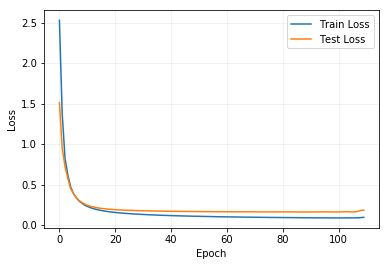

Fold 2 Held Out
Train Loss: 0.0743
Test Loss: 0.1628 



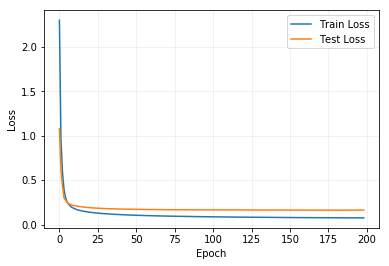

Fold 3 Held Out
Train Loss: 0.0818
Test Loss: 0.1609 



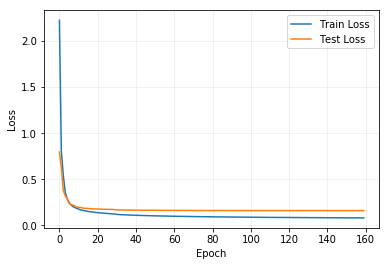

Fold 4 Held Out
Train Loss: 0.0868
Test Loss: 0.1657 



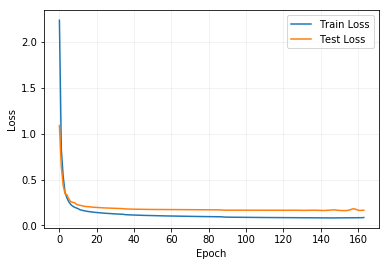

Fold 5 Held Out
Train Loss: 0.1074
Test Loss: 0.1877 



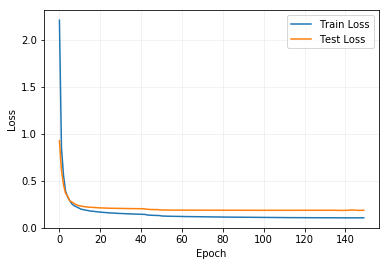

Fold 6 Held Out
Train Loss: 0.0999
Test Loss: 0.1872 



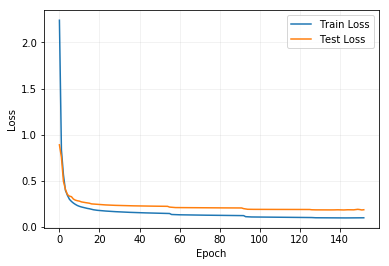

Fold 7 Held Out
Train Loss: 0.0894
Test Loss: 0.1383 



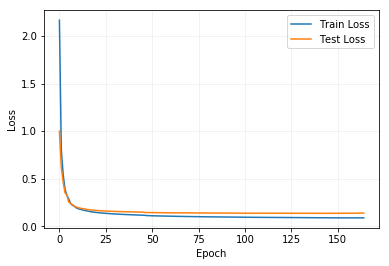

Fold 8 Held Out
Train Loss: 0.0764
Test Loss: 0.1416 



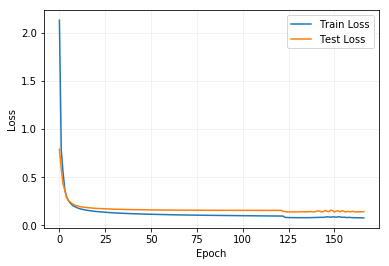

Fold 9 Held Out
Train Loss: 0.0872
Test Loss: 0.1757 



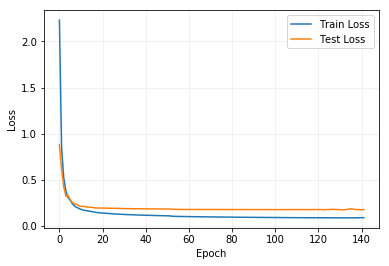

Fold 10 Held Out
Train Loss: 0.0833
Test Loss: 0.1908 



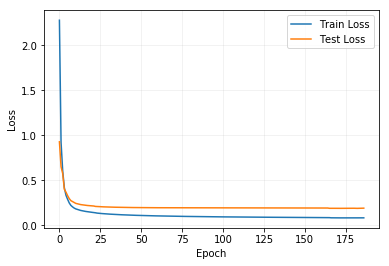

GlyNet Cross-Validation Complete


In [9]:
act_data, pred_data = train(plot=True)
act_data.to_csv('Results/Ground Truth.csv')
pred_data.to_csv('Results/Predictions.csv')

In [10]:
results = get_results(act_data, pred_data)
results.to_csv('Results/Metrics.csv', index=False)
print('Average MSE:', round(results['MSE'].mean(), 4))
print('Average R-Squared:', round(results['R-Squared'].mean(), 4))

Average MSE: 0.1696
Average R-Squared: 0.3021


In [12]:
predictable = get_predictable(results, cutoff=0.4)
print(len(predictable), 'Unique CBPs Ready for Prediction:', '\n')
for cbp in predictable:
    samples = predictable[cbp]
    print(*sorted(samples), sep=', ')

13 Unique CBPs Ready for Prediction: 

WT-VCC (180ug/ml)
LSL-150 0.2ug/ml, LSL-150 2ug/ml
LBL-152 0.2ug/ml, LBL-152 2ug/ml
AAL (0.1ug/ml), AAL (100 ug/ml)
ConA (1ug/ml), ConA (50ug/ml), ConA (5ug/ml)
LCA (100 ug/ml), LCA (10ug/ml), LCA (1ug/ml)
PHA-E (100ug/ml), PHA-E (10ug/ml)
PSA 100ug/ml, PSA 10ug/ml
CA 100ug/ml
LcH (10ug/ml)
AOL (Mahal Lab) (0.1ug/ml)
ConA 0.5ug/ml, ConA 100ug/ml , ConA 10ug/ml, ConA 1ug/ml, ConA 50ug/ml
WT (50ug/ml)


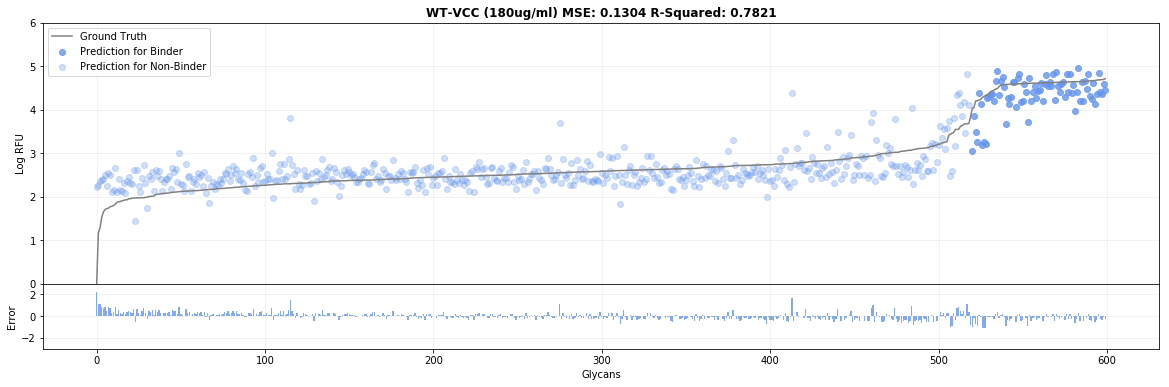

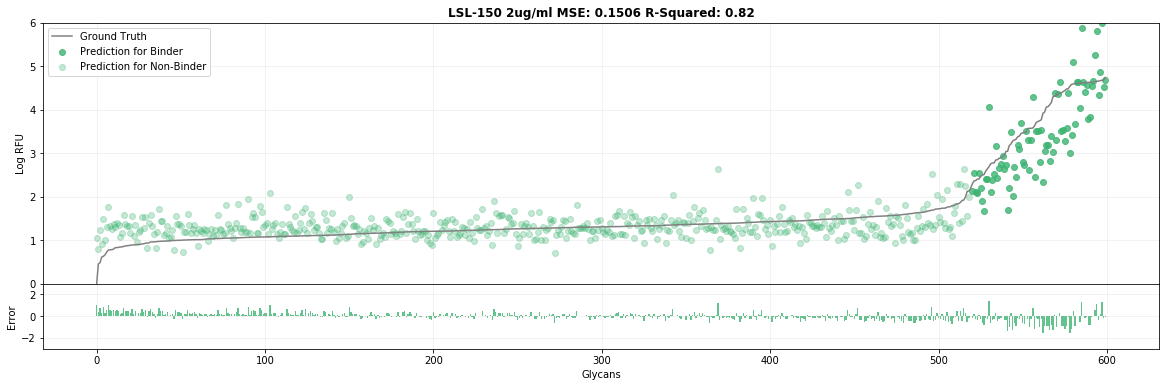

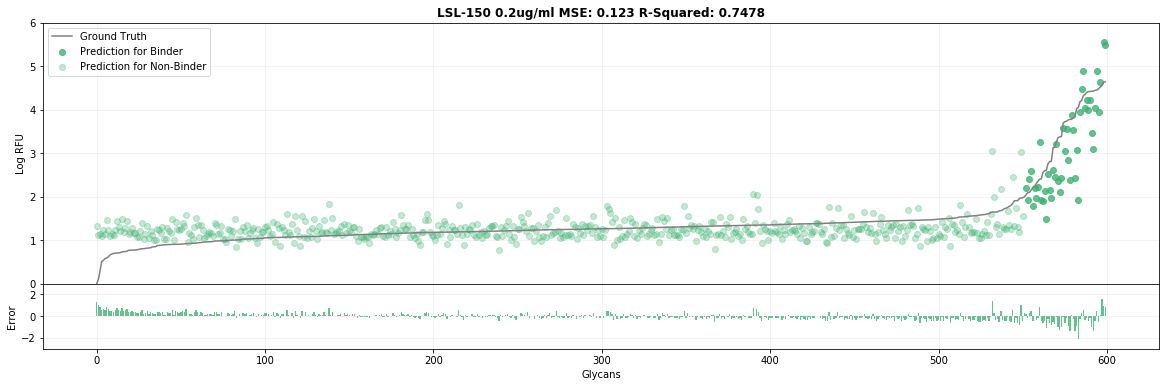

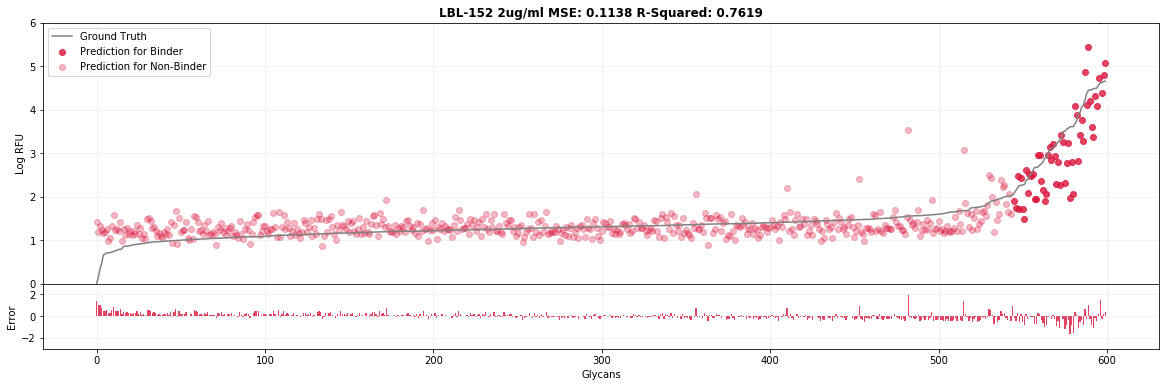

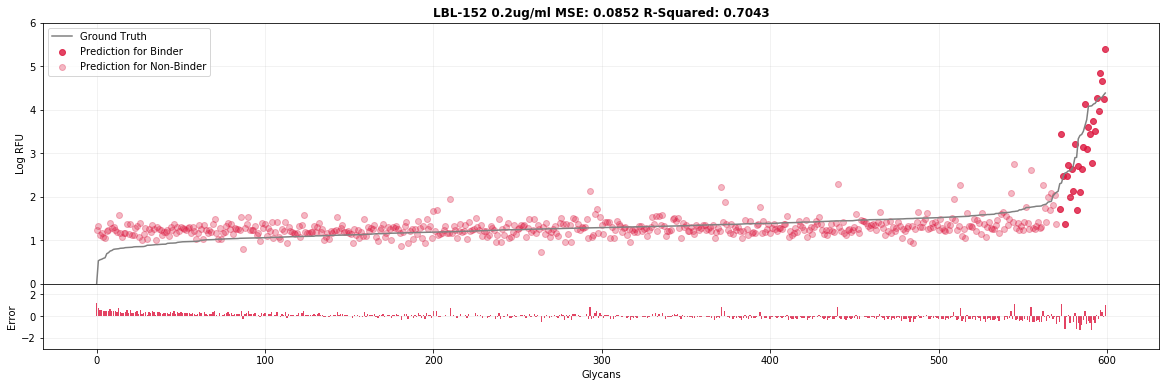

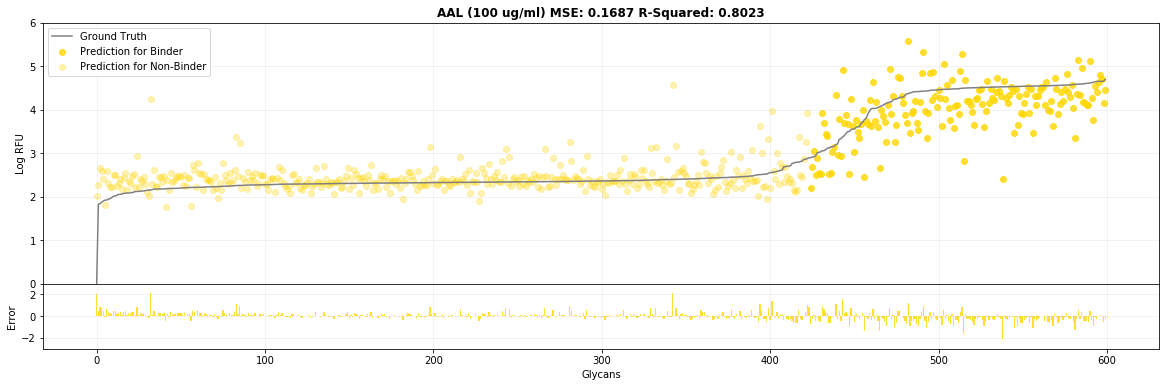

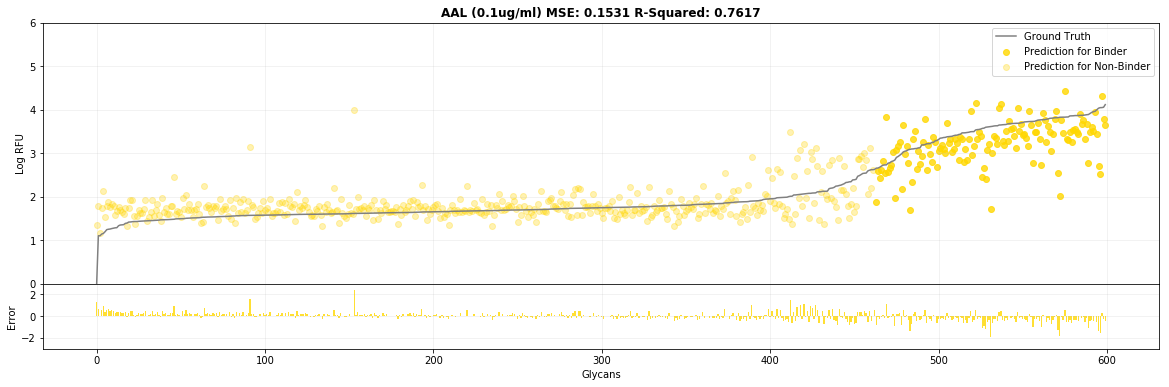

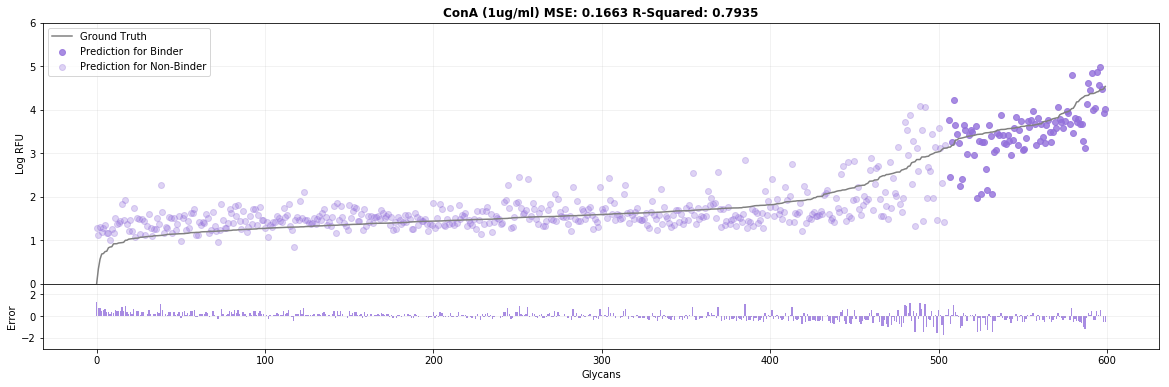

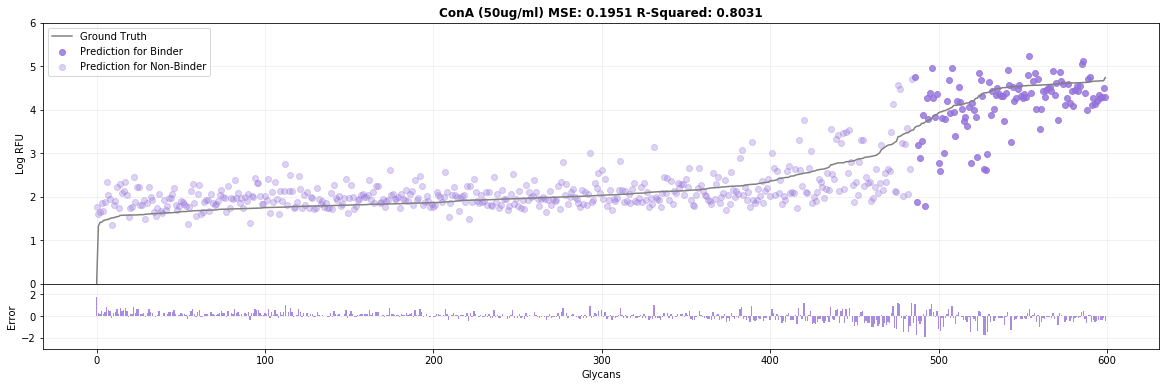

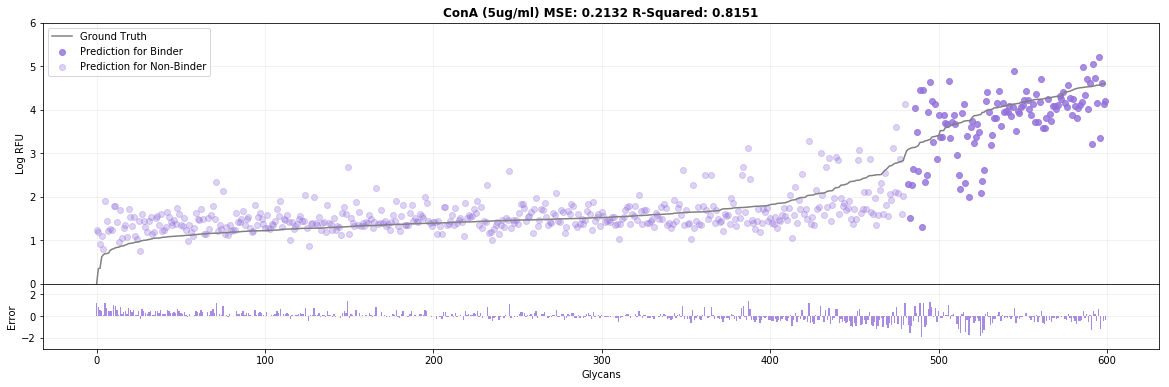

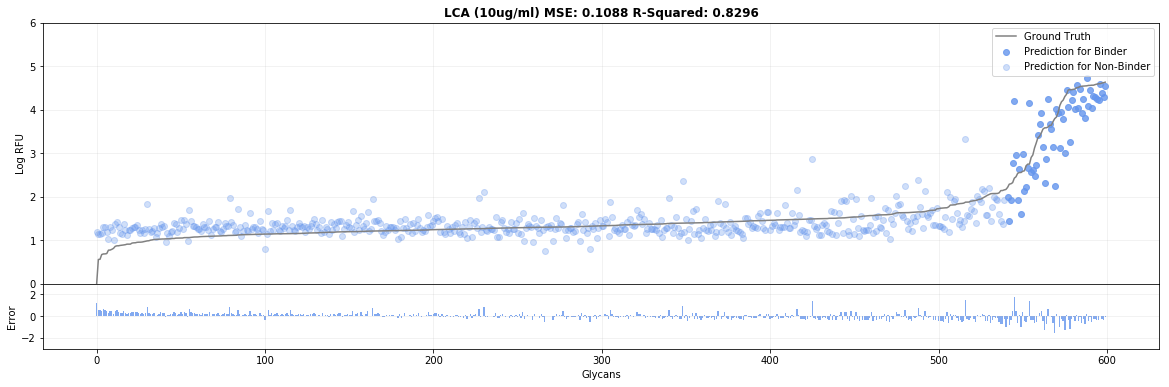

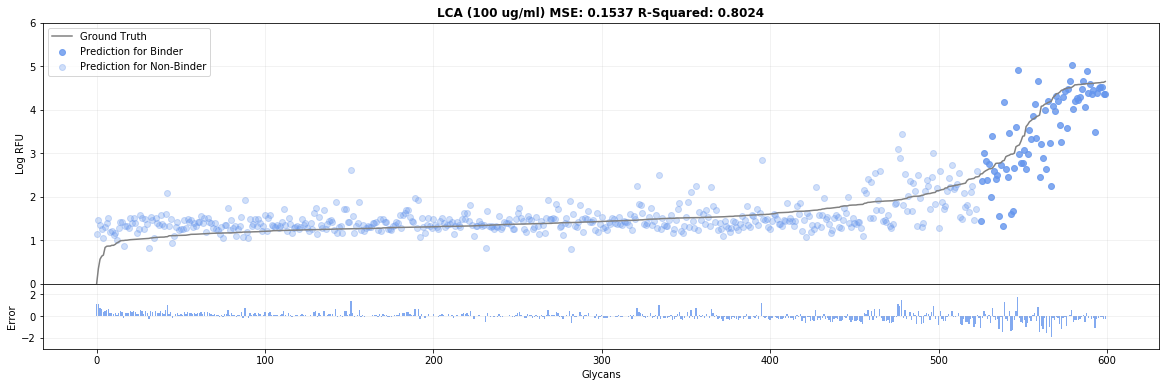

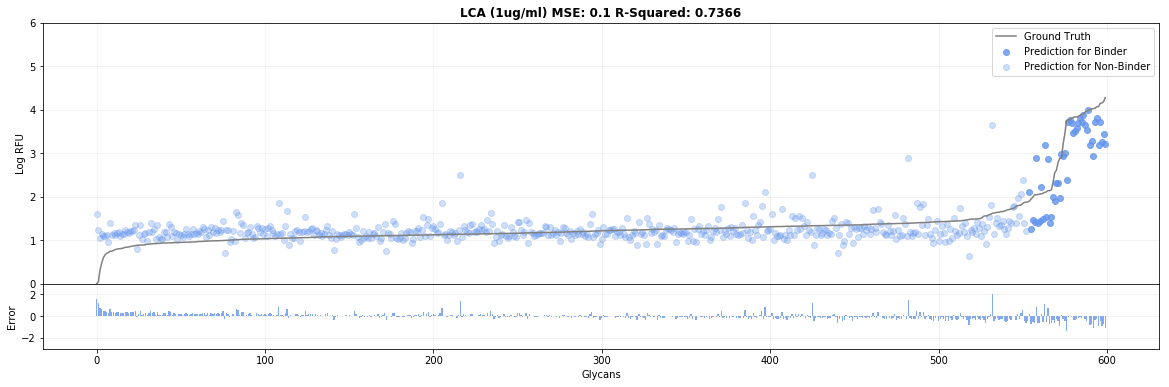

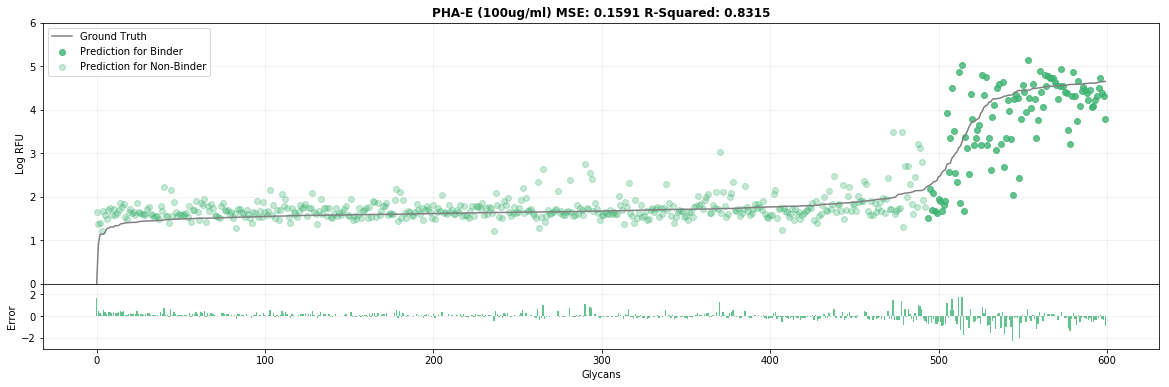

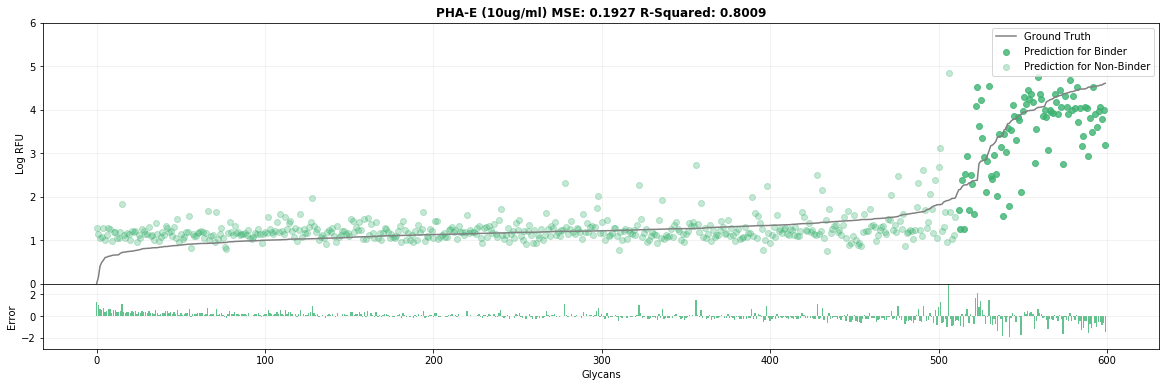

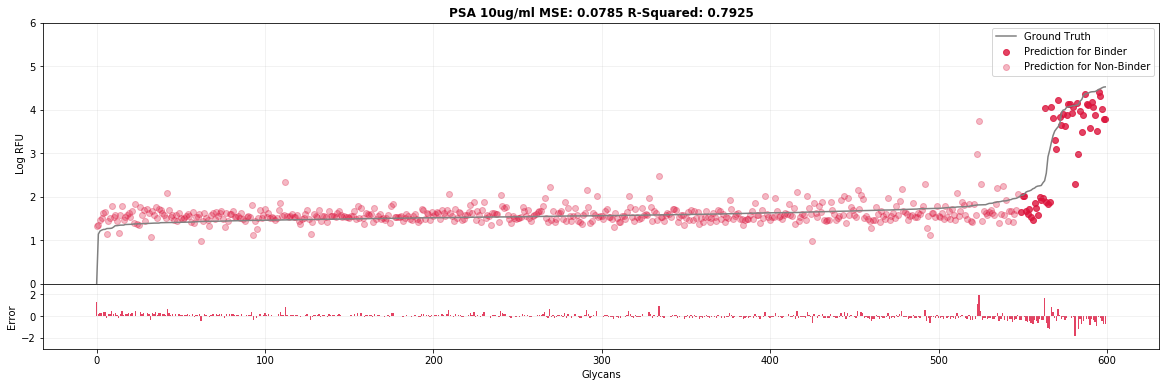

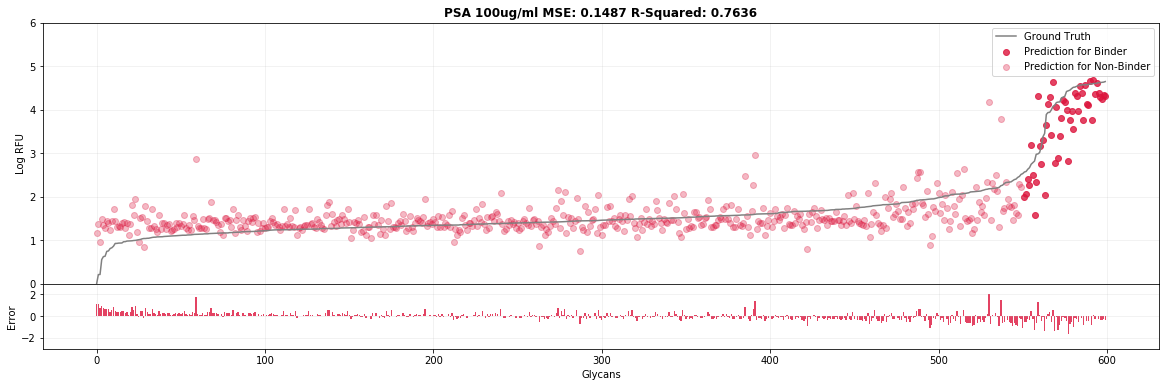

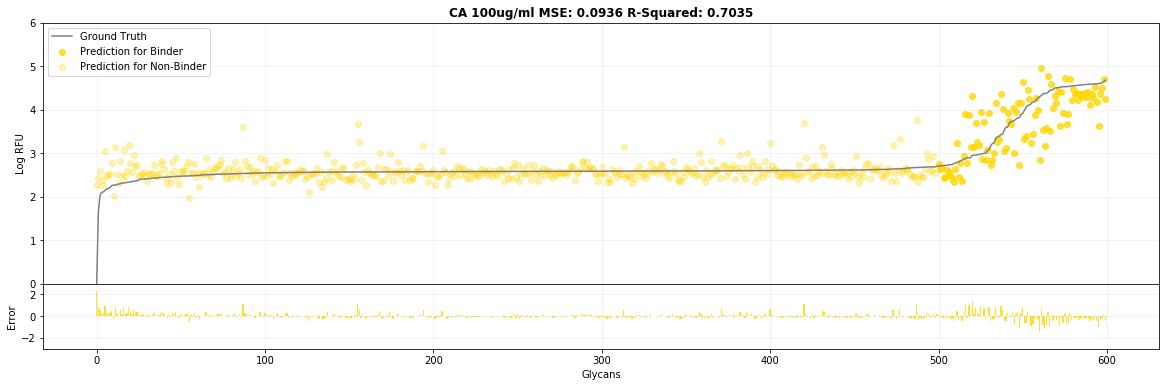

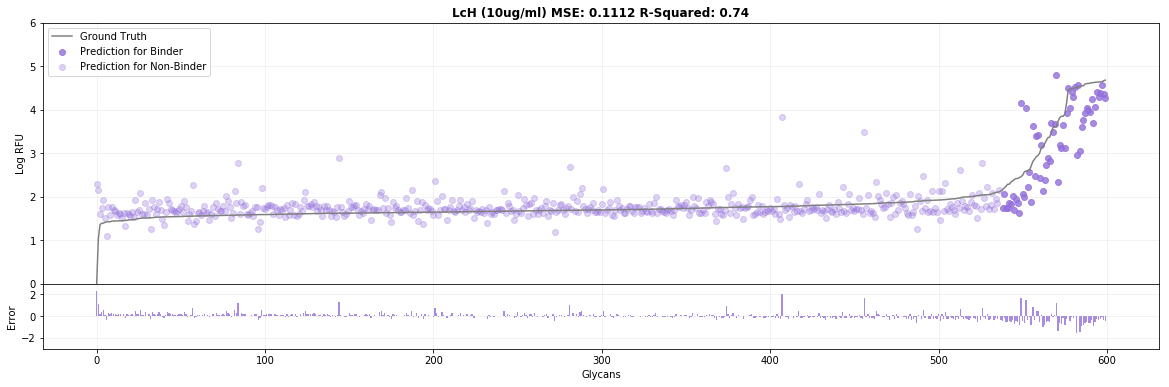

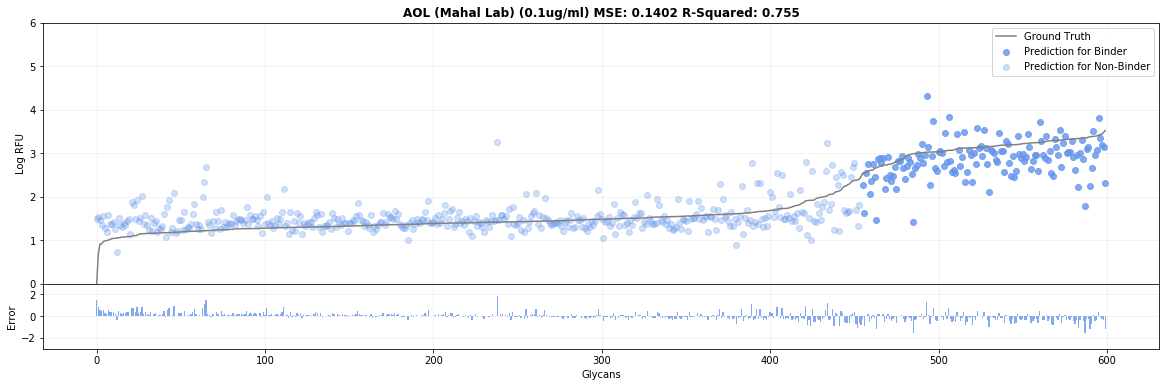

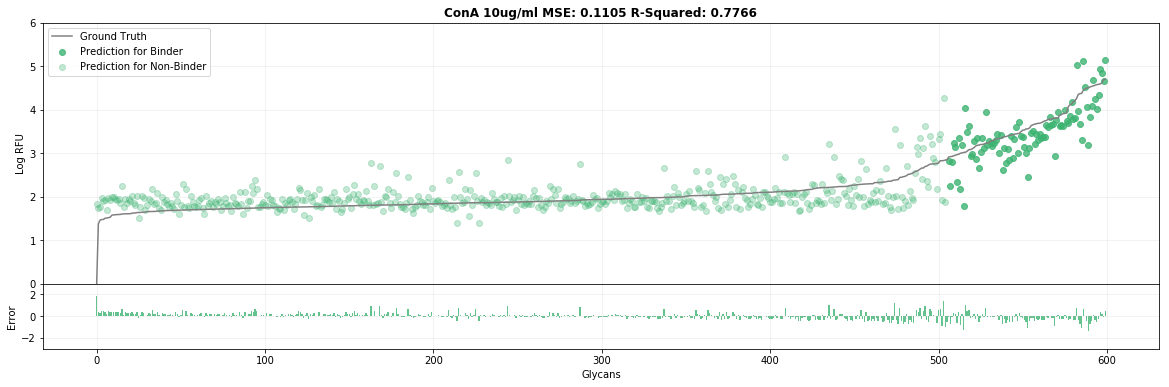

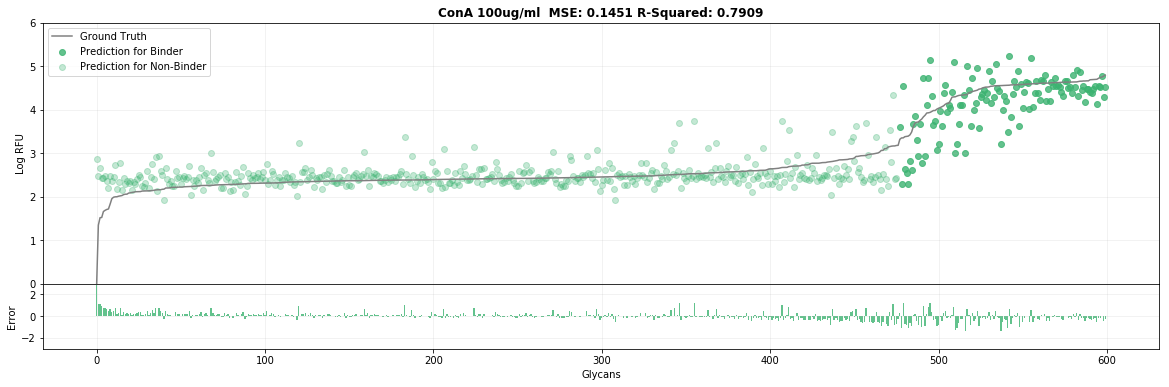

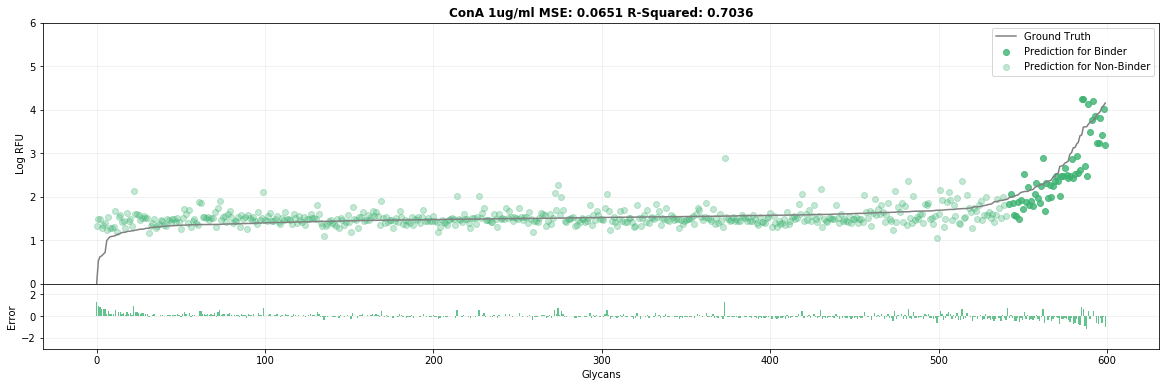

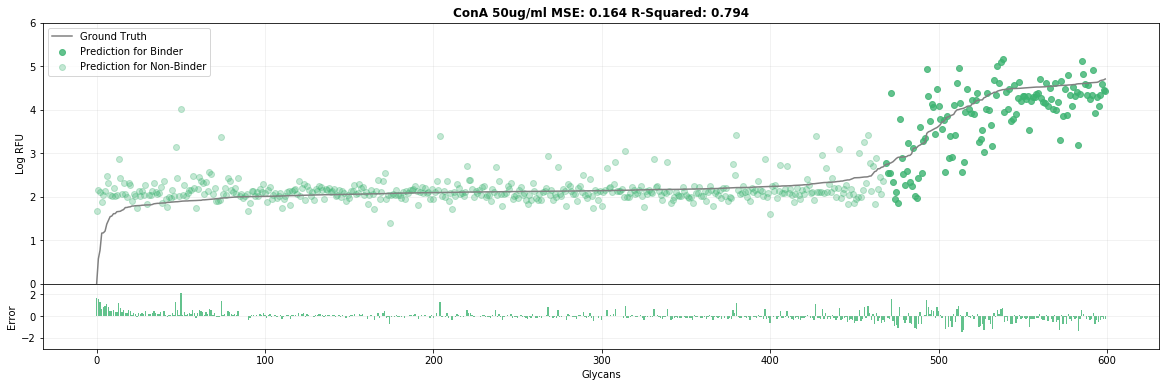

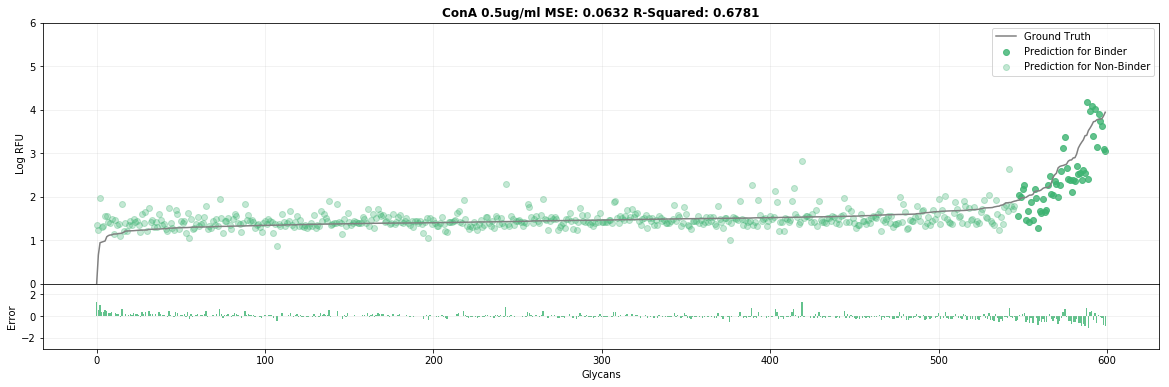

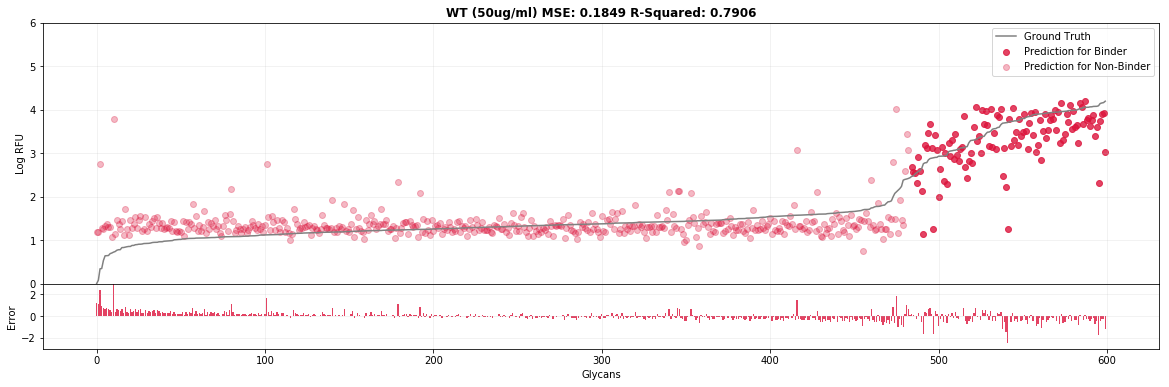

In [13]:
colors = ['cornflowerblue', 'mediumseagreen', 'crimson', 'gold', 'mediumpurple'] * 114
for i, cbpId in enumerate(predictable):
    for sample in predictable[cbpId]:
        plot_scatter(act_data[sample].values, pred_data[sample].values, sample, colors[i])